In [ ]:
##Warning PyOptPortfolio seems to encounter issues with the latest version of Python. This script was implemented using Python 3.8.18. Use Anaconda to create a virtual environment with the correct version of Python.

In [3]:
import pandas as pd
import numpy as np
import datetime as dt
import pandas_ta
import warnings
warnings.filterwarnings('ignore')

In [4]:
import yfinance as yf

nas100 = pd.read_html('https://en.wikipedia.org/wiki/Nasdaq-100')[4]

nas100['Ticker'] = nas100['Ticker'].str.replace('.','')
symbols_list = nas100['Ticker'].to_list()

#Download SP500 companies price data
end_date = '2023-09-01'
start_date = '2013-09-01'
df = yf.download(tickers=symbols_list,
                 start=start_date,
                 end=end_date,
                 interval='1d').stack()


#Assign multi-index
df.index.names = ['date', 'ticker']
df.columns = df.columns.str.lower()
df

[*********************100%%**********************]  101 of 101 completed


Price               adj close       close        high         low        open  \
date       ticker                                                               
2013-09-03 AAPL     15.189459   17.449286   17.878571   17.405357   17.610714   
           ADBE     45.880001   45.880001   46.570000   45.700001   46.209999   
           ADI      37.185482   46.660000   47.380001   46.549999   46.970001   
           ADP      49.738960   62.695347   63.608429   62.335381   63.195786   
           ADSK     37.130001   37.130001   37.709999   36.830002   37.110001   
...                       ...         ...         ...         ...         ...   
2023-08-31 WBA      24.447489   25.309999   25.760000   25.180000   25.590000   
           WBD      13.140000   13.140000   13.310000   13.100000   13.100000   
           WDAY    244.500000  244.500000  245.600006  242.220001  243.490005   
           XEL      56.145985   57.130001   58.080002   57.110001   57.959999   
           ZS      156.050003  156.050003  156.779999  148.970001  149.080002   

Price                   volume  
date       ticker               
2013-09-03 AAPL    331928800.0  
           ADBE      1955500.0  
           ADI       1808700.0  
           ADP       2068652.0  
           ADSK      1981300.0  
...                        ...  
2023-08-31 WBA      10794500.0  
           WBD      13170100.0  
           WDAY      1982900.0  
           XEL       3983700.0  
           ZS        2408300.0  

[234069 rows x 6 columns]

In [5]:
#Save data to pickle. So we don't have to download it again
df.to_pickle('nas100.pkl')

In [6]:
#Calculating features and technical indicator for each stock

df = pd.read_pickle('nas100.pkl')

#Calculate intraday volatility
df['garman_klass_vol'] = ((np.log(df['high'])-np.log(df['low']))**2)/2-(2*np.log(2)-1)*((np.log(df['adj close'])-np.log(df['open']))**2)
#Calculate RSI 
df['rsi'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.rsi(close=x, length=20))
#Calculate Bollinger Bands
df['bb_low'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,0])
df['bb_mid'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,1])                                                     
df['bb_high'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,2])
#Calculate ATR
def compute_atr(stock_data):
    atr = pandas_ta.atr(high=stock_data['high'],
                        low=stock_data['low'],
                        close=stock_data['close'],
                        length=14)
    return atr.sub(atr.mean()).div(atr.std())
df['atr'] = df.groupby(level=1, group_keys=False).apply(compute_atr)
#Calculate MACD
def compute_macd(close):
    macd = pandas_ta.macd(close=close, length=20).iloc[:,0]
    return macd.sub(macd.mean()).div(macd.std())
df['macd'] = df.groupby(level=1, group_keys=False)['adj close'].apply(compute_macd)

df

Price               adj close       close        high         low        open  \
date       ticker                                                               
2013-09-03 AAPL     15.189459   17.449286   17.878571   17.405357   17.610714   
           ADBE     45.880001   45.880001   46.570000   45.700001   46.209999   
           ADI      37.185482   46.660000   47.380001   46.549999   46.970001   
           ADP      49.738960   62.695347   63.608429   62.335381   63.195786   
           ADSK     37.130001   37.130001   37.709999   36.830002   37.110001   
...                       ...         ...         ...         ...         ...   
2023-08-31 WBA      24.447489   25.309999   25.760000   25.180000   25.590000   
           WBD      13.140000   13.140000   13.310000   13.100000   13.100000   
           WDAY    244.500000  244.500000  245.600006  242.220001  243.490005   
           XEL      56.145985   57.130001   58.080002   57.110001   57.959999   
           ZS      156.050003  156.050003  156.779999  148.970001  149.080002   

Price                   volume  garman_klass_vol        rsi    bb_low  \
date       ticker                                                       
2013-09-03 AAPL    331928800.0         -0.008091        NaN       NaN   
           ADBE      1955500.0          0.000158        NaN       NaN   
           ADI       1808700.0         -0.020922        NaN       NaN   
           ADP       2068652.0         -0.021944        NaN       NaN   
           ADSK      1981300.0          0.000279        NaN       NaN   
...                        ...               ...        ...       ...   
2023-08-31 WBA      10794500.0         -0.000547  29.871301  3.196775   
           WBD      13170100.0          0.000123  51.523409  2.566829   
           WDAY      1982900.0          0.000089  63.080675  5.393865   
           XEL       3983700.0         -0.000249  31.111547  4.035560   
           ZS        2408300.0          0.000499  58.148694  4.910349   

Price                bb_mid   bb_high       atr      macd  dollar_volume  
date       ticker                                                         
2013-09-03 AAPL         NaN       NaN       NaN       NaN    5041.818848  
           ADBE         NaN       NaN       NaN       NaN      89.718342  
           ADI          NaN       NaN       NaN       NaN      67.257381  
           ADP          NaN       NaN       NaN       NaN     102.892600  
           ADSK         NaN       NaN       NaN       NaN      73.565671  
...                     ...       ...       ...       ...            ...  
2023-08-31 WBA     3.303177  3.409580 -1.877969 -1.205722     263.898418  
           WBD     2.656860  2.746890 -0.995613  0.021000     173.055119  
           WDAY    5.446422  5.498978  0.498178  0.893549     484.819050  
           XEL     4.068309  4.101057  0.034156 -2.054612     223.668759  
           ZS      4.969052  5.027756 -0.077321 -0.095303     375.815222  

[234069 rows x 14 columns]

In [35]:
data = (df.drop(columns=['open', 'high', 'low', 'close', 'volume']) # Drop OHLCV columns
          .unstack('ticker')                 # Unstack ticker level to operate on the date level
          .resample('M').last()               # Resample to monthly frequency, taking the last value
          .stack('ticker')                    # Restack the ticker level back
          .dropna())                          # Drop NA values that might arise from resampling

data

Price               adj close  garman_klass_vol        rsi    bb_low  \
date       ticker                                                      
2013-10-31 AAPL     16.250221         -0.007839  60.463830  2.757071   
           ADBE     54.220001          0.000068  64.592177  3.924373   
           ADI      39.289410         -0.018114  62.166215  3.616171   
           ADP      52.570522         -0.017763  58.266147  3.912187   
           ADSK     39.900002          0.000065  49.738375  3.691016   
...                       ...               ...        ...       ...   
2023-08-31 WBA      24.447489         -0.000547  29.871301  3.196775   
           WBD      13.140000          0.000123  51.523409  2.566829   
           WDAY    244.500000          0.000089  63.080675  5.393865   
           XEL      56.145985         -0.000249  31.111547  4.035560   
           ZS      156.050003          0.000499  58.148694  4.910349   

Price                bb_mid   bb_high       atr      macd  
date       ticker                                          
2013-10-31 AAPL    2.819397  2.881722 -0.889989 -0.072893  
           ADBE    3.979666  4.034959 -1.028233 -0.022916  
           ADI     3.654887  3.693603 -1.130658 -0.103467  
           ADP     3.961864  4.011542 -1.049150 -0.034996  
           ADSK    3.724396  3.757776 -1.180104 -0.109737  
...                     ...       ...       ...       ...  
2023-08-31 WBA     3.303177  3.409580 -1.877969 -1.205722  
           WBD     2.656860  2.746890 -0.995613  0.021000  
           WDAY    5.446422  5.498978  0.498178  0.893549  
           XEL     4.068309  4.101057  0.034156 -2.054612  
           ZS      4.969052  5.027756 -0.077321 -0.095303  

[11064 rows x 8 columns]

In [36]:
#Calculate different time-horizon returns as features
def calculate_returns(df):
    outlier_cutoff = 0.005 #Exclude top and bottom 0.5% of observations(outliers)
    lags = [1, 2, 3, 6, 9, 12] #Different time-horizon returns
    for lag in lags:
        df[f'return_{lag}m'] = (df['adj close']
                              .pct_change(lag)
                              .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                                     upper=x.quantile(1-outlier_cutoff)))
                              .add(1)
                              .pow(1/lag)
                              .sub(1))
    return df    
data = data.groupby(level=1, group_keys=False).apply(calculate_returns).dropna()

data

Price               adj close  garman_klass_vol        rsi    bb_low  \
date       ticker                                                      
2014-10-31 AAPL     24.033798         -0.005210  66.482183  3.098430   
           ADBE     70.120003          0.000095  57.224432  4.124914   
           ADI      40.689034         -0.011640  58.249545  3.587549   
           ADP      66.858978         -0.013167  74.328093  4.061966   
           ADSK     57.540001          0.000131  60.226410  3.911548   
...                       ...               ...        ...       ...   
2023-08-31 WBA      24.447489         -0.000547  29.871301  3.196775   
           WBD      13.140000          0.000123  51.523409  2.566829   
           WDAY    244.500000          0.000089  63.080675  5.393865   
           XEL      56.145985         -0.000249  31.111547  4.035560   
           ZS      156.050003          0.000499  58.148694  4.910349   

Price                bb_mid   bb_high       atr      macd  return_1m  \
date       ticker                                                      
2014-10-31 AAPL    3.165043  3.231656 -0.834900 -0.019135   0.071960   
           ADBE    4.199365  4.273816 -0.915787 -0.145915   0.013441   
           ADI     3.655780  3.724011 -0.870182 -0.288467   0.002627   
           ADP     4.129114  4.196262 -0.791152  0.343150   0.121177   
           ADSK    4.007564  4.103581 -0.967347  0.006899   0.044283   
...                     ...       ...       ...       ...        ...   
2023-08-31 WBA     3.303177  3.409580 -1.877969 -1.205722  -0.140295   
           WBD     2.656860  2.746890 -0.995613  0.021000   0.005356   
           WDAY    5.446422  5.498978  0.498178  0.893549   0.031080   
           XEL     4.068309  4.101057  0.034156 -2.054612  -0.089271   
           ZS      4.969052  5.027756 -0.077321 -0.095303  -0.026998   

Price              return_2m  return_3m  return_6m  return_9m  return_12m  
date       ticker                                                          
2014-10-31 AAPL     0.026479   0.043214   0.043990   0.048790    0.033151  
           ADBE    -0.012456   0.004170   0.021577   0.019007    0.021661  
           ADI     -0.011160   0.002381  -0.003122   0.005485    0.002921  
           ADP      0.059362   0.048357   0.032140   0.024016    0.020238  
           ADSK     0.035716   0.025522   0.030603   0.012946    0.030979  
...                      ...        ...        ...        ...         ...  
2023-08-31 WBA     -0.049019  -0.053333  -0.049761  -0.048604   -0.022093  
           WBD      0.023644   0.052193  -0.028404   0.015908   -0.000632  
           WDAY     0.040377   0.048708   0.047131   0.042645    0.033545  
           XEL     -0.041391  -0.040887  -0.017537  -0.017177   -0.014377  
           ZS       0.032785   0.048245   0.029396   0.017535   -0.001685  

[9856 rows x 14 columns]

In [37]:
import pandas_datareader as pdr

#Download Fama-French 5 factors data
factor_data = pdr.data.DataReader('F-F_Research_Data_5_Factors_2x3', 'famafrench', start='2010')[0].drop('RF', axis=1)
factor_data.index = factor_data.index.to_timestamp()
#Resample to monthly frequency
factor_data = factor_data.resample('M').last().div(100)
factor_data.index.name = 'date'
#Merge with 1m return data
factor_data = factor_data.join(data['return_1m']).sort_index()

factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2014-10-31 AAPL    0.0252  0.0373 -0.0181 -0.0057 -0.0011   0.071960
           ADBE    0.0252  0.0373 -0.0181 -0.0057 -0.0011   0.013441
           ADI     0.0252  0.0373 -0.0181 -0.0057 -0.0011   0.002627
           ADP     0.0252  0.0373 -0.0181 -0.0057 -0.0011   0.121177
           ADSK    0.0252  0.0373 -0.0181 -0.0057 -0.0011   0.044283
...                   ...     ...     ...     ...     ...        ...
2023-08-31 WBA    -0.0239 -0.0365 -0.0106  0.0343 -0.0237  -0.140295
           WBD    -0.0239 -0.0365 -0.0106  0.0343 -0.0237   0.005356
           WDAY   -0.0239 -0.0365 -0.0106  0.0343 -0.0237   0.031080
           XEL    -0.0239 -0.0365 -0.0106  0.0343 -0.0237  -0.089271
           ZS     -0.0239 -0.0365 -0.0106  0.0343 -0.0237  -0.026998

[9856 rows x 6 columns]

In [38]:
#Filter out stocks with less than 12 monthly observations, needed for OLS Regression

observations = factor_data.groupby(level=1).size()
valid_stocks = observations[observations >= 12]

factor_data = factor_data[factor_data.index.get_level_values('ticker').isin(valid_stocks.index)]

factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2014-10-31 AAPL    0.0252  0.0373 -0.0181 -0.0057 -0.0011   0.071960
           ADBE    0.0252  0.0373 -0.0181 -0.0057 -0.0011   0.013441
           ADI     0.0252  0.0373 -0.0181 -0.0057 -0.0011   0.002627
           ADP     0.0252  0.0373 -0.0181 -0.0057 -0.0011   0.121177
           ADSK    0.0252  0.0373 -0.0181 -0.0057 -0.0011   0.044283
...                   ...     ...     ...     ...     ...        ...
2023-08-31 WBA    -0.0239 -0.0365 -0.0106  0.0343 -0.0237  -0.140295
           WBD    -0.0239 -0.0365 -0.0106  0.0343 -0.0237   0.005356
           WDAY   -0.0239 -0.0365 -0.0106  0.0343 -0.0237   0.031080
           XEL    -0.0239 -0.0365 -0.0106  0.0343 -0.0237  -0.089271
           ZS     -0.0239 -0.0365 -0.0106  0.0343 -0.0237  -0.026998

[9840 rows x 6 columns]

In [39]:
from statsmodels.regression.rolling import RollingOLS
import matplotlib.pyplot as plt
import statsmodels.api as sm

#Perform OLS Regression to calculate beta of each factor for each stock.
betas = (factor_data.groupby(level=1,
                            group_keys=False)
         .apply(lambda x: RollingOLS(endog=x['return_1m'], 
                                     exog=sm.add_constant(x.drop('return_1m', axis=1)),
                                     window=min(24, x.shape[0]),
                                     min_nobs=len(x.columns)+1)
         .fit(params_only=True)
         .params
         .drop('const', axis=1)))

betas

Mkt-RF       SMB       HML       RMW       CMA
date       ticker                                                  
2014-10-31 AAPL         NaN       NaN       NaN       NaN       NaN
           ADBE         NaN       NaN       NaN       NaN       NaN
           ADI          NaN       NaN       NaN       NaN       NaN
           ADP          NaN       NaN       NaN       NaN       NaN
           ADSK         NaN       NaN       NaN       NaN       NaN
...                     ...       ...       ...       ...       ...
2023-08-31 WBA     1.074117  0.521634  0.092614  0.965097  0.947677
           WBD     1.640813  0.271859  1.937449 -0.582993 -1.661173
           WDAY    1.078621 -0.927459 -0.588759 -0.837588 -0.234223
           XEL     0.604914 -0.403346 -0.531159 -0.090058  1.281134
           ZS      0.396146  0.398218  0.075157 -0.718057 -2.433396

[9840 rows x 5 columns]

In [40]:
#Merge beta data with original data, shift by 1 month to avoid look-ahead bias
data = (data.join(betas.groupby('ticker').shift()))
#Fill missing values with mean of the respective factor for each stock
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']
data.loc[:, factors] = data.groupby('ticker', group_keys=False)[factors].apply(lambda x: x.fillna(x.mean()))
#Drop missing values, and adjust close column
data = data.drop('adj close', axis=1)
data = data.dropna()

data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 9800 entries, (Timestamp('2014-10-31 00:00:00'), 'AAPL') to (Timestamp('2023-08-31 00:00:00'), 'ZS')
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   garman_klass_vol  9800 non-null   float64
 1   rsi               9800 non-null   float64
 2   bb_low            9800 non-null   float64
 3   bb_mid            9800 non-null   float64
 4   bb_high           9800 non-null   float64
 5   atr               9800 non-null   float64
 6   macd              9800 non-null   float64
 7   return_1m         9800 non-null   float64
 8   return_2m         9800 non-null   float64
 9   return_3m         9800 non-null   float64
 10  return_6m         9800 non-null   float64
 11  return_9m         9800 non-null   float64
 12  return_12m        9800 non-null   float64
 13  Mkt-RF            9800 non-null   float64
 14  SMB               9800 non-null   float64
 15  HML         

In [42]:
#Define cluster RSI values (high-selling, selling, buying, high-buying)
target_rsi_values = [30, 45,  55, 70]

#Create initial centroids, fix RSI values, and set other values to 0
initial_centroids = np.zeros((len(target_rsi_values), 18))
initial_centroids[:, 1] = target_rsi_values
initial_centroids

array([[ 0., 30.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0., 45.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0., 55.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0., 70.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.]])

In [43]:
from sklearn.cluster import KMeans

#Create a function to get clusters
def get_clusters(df):
    #Apply KMeans clustering to each month of data separately
    df['cluster'] = KMeans(n_clusters=4,
                           random_state=0,
                           init=initial_centroids).fit(df).labels_
    return df
data = data.dropna().groupby('date', group_keys=False).apply(get_clusters)

data

garman_klass_vol        rsi    bb_low    bb_mid   bb_high  \
date       ticker                                                              
2014-10-31 AAPL           -0.005210  66.482183  3.098430  3.165043  3.231656   
           ADBE            0.000095  57.224432  4.124914  4.199365  4.273816   
           ADI            -0.011640  58.249545  3.587549  3.655780  3.724011   
           ADP            -0.013167  74.328093  4.061966  4.129114  4.196262   
           ADSK            0.000131  60.226410  3.911548  4.007564  4.103581   
...                             ...        ...       ...       ...       ...   
2023-08-31 WBA            -0.000547  29.871301  3.196775  3.303177  3.409580   
           WBD             0.000123  51.523409  2.566829  2.656860  2.746890   
           WDAY            0.000089  63.080675  5.393865  5.446422  5.498978   
           XEL            -0.000249  31.111547  4.035560  4.068309  4.101057   
           ZS              0.000499  58.148694  4.910349  4.969052  5.027756   

                        atr      macd  return_1m  return_2m  return_3m  \
date       ticker                                                        
2014-10-31 AAPL   -0.834900 -0.019135   0.071960   0.026479   0.043214   
           ADBE   -0.915787 -0.145915   0.013441  -0.012456   0.004170   
           ADI    -0.870182 -0.288467   0.002627  -0.011160   0.002381   
           ADP    -0.791152  0.343150   0.121177   0.059362   0.048357   
           ADSK   -0.967347  0.006899   0.044283   0.035716   0.025522   
...                     ...       ...        ...        ...        ...   
2023-08-31 WBA    -1.877969 -1.205722  -0.140295  -0.049019  -0.053333   
           WBD    -0.995613  0.021000   0.005356   0.023644   0.052193   
           WDAY    0.498178  0.893549   0.031080   0.040377   0.048708   
           XEL     0.034156 -2.054612  -0.089271  -0.041391  -0.040887   
           ZS     -0.077321 -0.095303  -0.026998   0.032785   0.048245   

                   return_6m  return_9m  return_12m    Mkt-RF       SMB  \
date       ticker                                                         
2014-10-31 AAPL     0.043990   0.048790    0.033151  1.091320 -0.125937   
           ADBE     0.021577   0.019007    0.021661  0.937350 -0.343301   
           ADI     -0.003122   0.005485    0.002921  0.997276  0.591314   
           ADP      0.032140   0.024016    0.020238  0.782738  0.179227   
           ADSK     0.030603   0.012946    0.030979  1.379577 -0.117997   
...                      ...        ...         ...       ...       ...   
2023-08-31 WBA     -0.049761  -0.048604   -0.022093  1.069629  0.098841   
           WBD     -0.028404   0.015908   -0.000632  1.668582  0.618122   
           WDAY     0.047131   0.042645    0.033545  1.140960 -1.020895   
           XEL     -0.017537  -0.017177   -0.014377  0.572587 -0.608482   
           ZS       0.029396   0.017535   -0.001685  0.404354  0.046386   

                        HML       RMW       CMA  cluster  
date       ticker                                         
2014-10-31 AAPL   -0.383112  0.729772 -0.814686        3  
           ADBE   -0.135355 -0.507898 -1.213022        2  
           ADI     0.258439  0.067461 -0.670494        2  
           ADP    -0.052080  0.090685  0.191349        3  
           ADSK    0.101847 -1.119145 -1.402203        2  
...                     ...       ...       ...      ...  
2023-08-31 WBA     0.436157  0.972612  0.397461        0  
           WBD     1.661248 -0.641781 -1.203884        1  
           WDAY   -0.499282 -0.974276 -0.338290        3  
           XEL    -0.370928 -0.020550  1.005829        0  
           ZS      0.363596 -0.737893 -2.887960        2  

[9800 rows x 19 columns]

In [56]:
#Create function to plot clusters
def plot_clusters(data):

    cluster_0 = data[data['cluster']==0]
    cluster_1 = data[data['cluster']==1]
    cluster_2 = data[data['cluster']==2]
    cluster_3 = data[data['cluster']==3]

    #Plot clusters based on ATR and RSI
    plt.scatter(cluster_0.iloc[:,5] , cluster_0.iloc[:,1] , color = 'red', label='high-selling')
    plt.scatter(cluster_1.iloc[:,5] , cluster_1.iloc[:,1] , color = 'green', label='selling')
    plt.scatter(cluster_2.iloc[:,5] , cluster_2.iloc[:,1] , color = 'blue', label='buying')
    plt.scatter(cluster_3.iloc[:,5] , cluster_3.iloc[:,1] , color = 'black', label='high-buying')
    
    plt.legend()
    plt.show()
    return

In [ ]:
plt.style.use('ggplot')

#For each month of data, plot clusters
for i in data.index.get_level_values('date').unique().tolist():
    g = data.xs(i, level=0)
    plt.title(f'Date {i}')
    plot_clusters(g)

In [46]:
#Select data where RSI is in the high-buying cluster
filtered_df = data[data['cluster']==3].copy()
filtered_df = filtered_df.reset_index(level=1)

#Shift the date index by 1 day to avoid look-ahead bias
filtered_df.index = filtered_df.index+pd.DateOffset(1)
filtered_df = filtered_df.reset_index().set_index(['date', 'ticker'])

#Get the dates and tickers where RSI is in the high-buying cluster, and save to dictionary 
dates = filtered_df.index.get_level_values('date').unique().tolist()
portfolio_allocator = {}
for d in dates:
    portfolio_allocator[d.strftime('%Y-%m-%d')] = filtered_df.xs(d, level=0).index.tolist()

portfolio_allocator

{'2014-11-01': ['AAPL',
  'ADP',
  'AEP',
  'AMGN',
  'COST',
  'CSX',
  'CTAS',
  'CTSH',
  'DLTR',
  'EA',
  'IDXX',
  'ILMN',
  'KDP',
  'MAR',
  'MELI',
  'MNST',
  'ORLY',
  'PAYX',
  'PCAR',
  'ROP',
  'ROST',
  'TTWO',
  'WDAY',
  'XEL'],
 '2014-12-01': ['AAPL',
  'ADI',
  'ADP',
  'ADSK',
  'AMAT',
  'AMGN',
  'ANSS',
  'CDW',
  'CHTR',
  'COST',
  'CPRT',
  'CSCO',
  'CSGP',
  'CTAS',
  'CTSH',
  'DLTR',
  'EA',
  'HON',
  'IDXX',
  'INTC',
  'INTU',
  'KDP',
  'KLAC',
  'LRCX',
  'LULU',
  'MAR',
  'MDLZ',
  'MELI',
  'MNST',
  'MU',
  'NVDA',
  'NXPI',
  'ODFL',
  'ORLY',
  'PANW',
  'PAYX',
  'PCAR',
  'PEP',
  'ROST',
  'SBUX',
  'SNPS',
  'TTWO',
  'TXN',
  'WBA'],
 '2015-01-01': ['CSGP',
  'CTAS',
  'DLTR',
  'EA',
  'FTNT',
  'LULU',
  'ON',
  'ORLY',
  'ROST',
  'WBA'],
 '2015-02-01': ['AMZN', 'BIIB', 'EA', 'LULU', 'NFLX', 'SBUX'],
 '2015-03-01': ['ADBE',
  'ADSK',
  'AMZN',
  'AVGO',
  'BIIB',
  'BKNG',
  'CTAS',
  'CTSH',
  'DLTR',
  'EA',
  'INTU',
  'LULU',
  'MCHP

In [47]:
#Download new daily data for backtesting purposes based on tickers list from transformed data.
stocks = data.index.get_level_values('ticker').unique().tolist()
new_df = yf.download(tickers=stocks,
                     start=data.index.get_level_values('date').unique()[0]-pd.DateOffset(months=12),
                     end=data.index.get_level_values('date').unique()[-1])

new_df

[*********************100%%**********************]  96 of 96 completed


Price        Adj Close                                                  \
Ticker            AAPL        ADBE         ADI         ADP        ADSK   
Date                                                                     
2013-10-31   16.250217   54.220001   39.289429   52.570522   39.900002   
2013-11-01   16.167210   54.610001   39.592270   52.766705   41.889999   
2013-11-04   16.376131   55.389999   39.177834   52.906834   41.799999   
2013-11-05   16.335722   54.790001   39.679920   52.906834   41.709999   
2013-11-06   16.289438   54.880001   39.791496   53.131054   42.020000   
...                ...         ...         ...         ...         ...   
2023-08-24  175.923462  512.429993  172.057571  247.058578  208.600006   
2023-08-25  178.147690  525.059998  176.485565  250.272919  215.919998   
2023-08-28  179.723602  529.919983  178.635178  251.598206  217.089996   
2023-08-29  183.643402  540.570007  180.844208  251.558655  219.399994   
2023-08-30  187.164276  545.359985  179.863525  252.132278  221.550003   

Price                                                                  ...  \
Ticker            AEP        AMAT         AMD        AMGN        AMZN  ...   
Date                                                                   ...   
2013-10-31  32.109589   15.457606    3.340000   87.211281   18.201500  ...   
2013-11-01  32.246693   15.319133    3.310000   89.126099   17.950001  ...   
2013-11-04  32.349506   15.362406    3.320000   88.067299   17.937000  ...   
2013-11-05  31.924494   15.379718    3.330000   86.460358   17.944500  ...   
2013-11-06  32.388786   15.509535    3.320000   85.101181   17.809000  ...   
...               ...         ...         ...         ...         ...  ...   
2023-08-24  77.055382  142.214432  101.800003  252.643005  131.839996  ...   
2023-08-25  77.544128  144.050491  102.250000  252.406738  133.259995  ...   
2023-08-28  77.417046  145.108215  102.610001  252.574081  133.139999  ...   
2023-08-29  77.837364  149.658432  105.919998  255.616211  134.910004  ...   
2023-08-30  77.651649  150.626358  106.589996  253.883484  135.070007  ...   

Price          Volume                                                          \
Ticker            TTD     TTWO      TXN     VRSK     VRTX       WBA       WBD   
Date                                                                            
2013-10-31        NaN  7464900  9643500   474600  2462000   4718000   5369812   
2013-11-01        NaN  3833200  6033800   847100  3938900   5353700   4058622   
2013-11-04        NaN  3656500  3681600   517200  2780900   4725900   2852523   
2013-11-05        NaN  3039800  5350400   799800  1903000   4166700   2532162   
2013-11-06        NaN  2610700  4637300  5231700  4705500   3893800   2068940   
...               ...      ...      ...      ...      ...       ...       ...   
2023-08-24  2605100.0  1404300  6003200   743100   704400  13169200  14044800   
2023-08-25  2439600.0  1419200  3947500   907400   697900  10937800  18874000   
2023-08-28  1898600.0   620700  3995100   590800   552500   8282300  15302700   
2023-08-29  2436100.0   785600  3981700   662200   882600   6892600  11313300   
2023-08-30  2358700.0   583900  5120400   786000   640500   5883700   9543400   

Price                                    
Ticker         WDAY      XEL         ZS  
Date                                     
2013-10-31   436200  3095900        NaN  
2013-11-01   761400  2164100        NaN  
2013-11-04   597200  1634600        NaN  
2013-11-05   760600  3009600        NaN  
2013-11-06   865000  3025400        NaN  
...             ...      ...        ...  
2023-08-24  3629700  5780900  1138200.0  
2023-08-25  5637100  7705600  1038000.0  
2023-08-28  1879000  3982200  1171400.0  
2023-08-29  1848800  4614900  1015800.0  
2023-08-30  1644100  2583500  1081400.0  

[2474 rows x 576 columns]

In [48]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

#Create a function to optimize weights
def optimize_weights(prices, lower_bound=0):
    #Calculate expected returns 
    returns = expected_returns.mean_historical_return(prices=prices,
                                                      frequency=252)
    #Calculate covariance matrix
    cov = risk_models.sample_cov(prices=prices,
                                 frequency=252)
    #Create an EfficientFrontier object
    ef = EfficientFrontier(expected_returns=returns,
                           cov_matrix=cov,
                           weight_bounds=(lower_bound, .1),
                           solver='SCS')
    #Get the weights that maximize the Sharpe ratio
    weights = ef.max_sharpe()
    
    return ef.clean_weights()

In [49]:
# Define a function to calculate portfolio returns based on optimization or equal weighting.
def calculate_portfolio_returns(new_df, fixed_dates, returns_dataframe):
    portfolio_df = pd.DataFrame()

    # Iterate over each start date specified in the 'portfolio_allocator' dictionary.
    for start_date in portfolio_allocator.keys():
        try:
            # Calculate the end date for the current period as the last day of the start date's month.
            end_date = (pd.to_datetime(start_date) + pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')
            # Retrieve the list of tickers to be included in the optimization for the current start date.
            cols = portfolio_allocator[start_date]

            # Determine the date range for optimization: start 12 months before the current start date and end one day before.
            optimization_start_date = (pd.to_datetime(start_date) - pd.DateOffset(months=12)).strftime('%Y-%m-%d')
            optimization_end_date = (pd.to_datetime(start_date) - pd.DateOffset(days=1)).strftime('%Y-%m-%d')

            # Extract the adjusted close prices for the tickers and time period identified for optimization.
            optimization_df = new_df[optimization_start_date:optimization_end_date]['Adj Close'][cols]

            try:
                # Attempt to calculate optimal weights using a predefined optimization function.
                # The lower bound for weights is set dynamically based on the number of assets.
                weights = optimize_weights(prices=optimization_df,
                                           lower_bound=round(1 / (len(optimization_df.columns) * 2), 3))
                success = True
            except Exception as e:
                # If optimization fails, print an error message and continue with equal weights.
                print(f'Max Sharpe Optimization failed for {start_date} due to {e}, Continuing with Equal-Weights')
                success = False

            # If optimization was not successful, use equal weighting for all tickers.
            if not success:
                equal_weight = 1 / len(cols)
                weights = {ticker: equal_weight for ticker in cols}

            # Convert the weights dictionary into a DataFrame for easier calculations.
            weights_df = pd.DataFrame(weights, index=[0])

            # Retrieve returns data for the current period and tickers.
            temp_df = returns_dataframe.loc[start_date:end_date, cols]
            # Multiply the returns by the weights to calculate weighted returns.
            temp_df = temp_df.mul(weights_df.values, axis=1)
            # Sum the weighted returns across all tickers to get the portfolio's strategy return for each day.
            temp_df['Strategy Return'] = temp_df.sum(axis=1)

            # Append the calculated strategy returns to the portfolio returns DataFrame.
            portfolio_df = pd.concat([portfolio_df, temp_df[['Strategy Return']]], axis=0)

        except Exception as e:
            # If an error occurs during processing, print an error message.
            print(f'Error processing {start_date}: {e}')

    # Remove any duplicate entries in the portfolio returns DataFrame.
    portfolio_df = portfolio_df.drop_duplicates()
    # Return the final portfolio returns DataFrame.
    return portfolio_df


In [59]:
# Calculate the portfolio returns using the defined function.

returns_dataframe = np.log(new_df['Adj Close']).diff()
portfolio_df = calculate_portfolio_returns(new_df, portfolio_allocator, returns_dataframe)
portfolio_df

Max Sharpe Optimization failed for 2015-02-01 due to ('Please check your objectives/constraints or use a different solver.', 'Solver status: infeasible'), Continuing with Equal-Weights
Max Sharpe Optimization failed for 2015-07-01 due to ('Please check your objectives/constraints or use a different solver.', 'Solver status: infeasible'), Continuing with Equal-Weights
Max Sharpe Optimization failed for 2015-10-01 due to ('Please check your objectives/constraints or use a different solver.', 'Solver status: infeasible'), Continuing with Equal-Weights
Max Sharpe Optimization failed for 2016-02-01 due to ('Please check your objectives/constraints or use a different solver.', 'Solver status: infeasible'), Continuing with Equal-Weights
Max Sharpe Optimization failed for 2017-01-01 due to ('Please check your objectives/constraints or use a different solver.', 'Solver status: infeasible'), Continuing with Equal-Weights
Max Sharpe Optimization failed for 2018-04-01 due to ('Please check your ob

Ticker,Strategy Return
Date,
2014-11-03,0.003193
2014-11-04,-0.005288
2014-11-05,0.000055
2014-11-06,0.005416
2014-11-07,0.006164
...,...
2023-08-24,-0.016455
2023-08-25,0.005532
2023-08-28,0.011222


In [60]:
#Download NASDAQ data for comparison
nasdaq = yf.download(tickers='^IXIC',
                  start='2014-11-01',
                  end=dt.date.today())

nasdaq_ret = np.log(nasdaq[['Adj Close']]).diff().dropna().rename({'Adj Close':'NASDAQ Buy&Hold'}, axis=1)

#Merge the portfolio returns with the NASDAQ returns
portfolio_df = portfolio_df.merge(nasdaq_ret,
                                  left_index=True,
                                  right_index=True)

portfolio_df

[*********************100%%**********************]  1 of 1 completed


,Strategy Return,NASDAQ Buy&Hold
Date,,
2014-11-04,-0.005288,-0.003297
2014-11-05,0.000055,-0.000632
2014-11-06,0.005416,0.003834
2014-11-07,0.006164,-0.001282
2014-11-10,0.006598,0.004112
...,...,...
2023-08-24,-0.016455,-0.018913
2023-08-25,0.005532,0.009365
2023-08-28,0.011222,0.008388


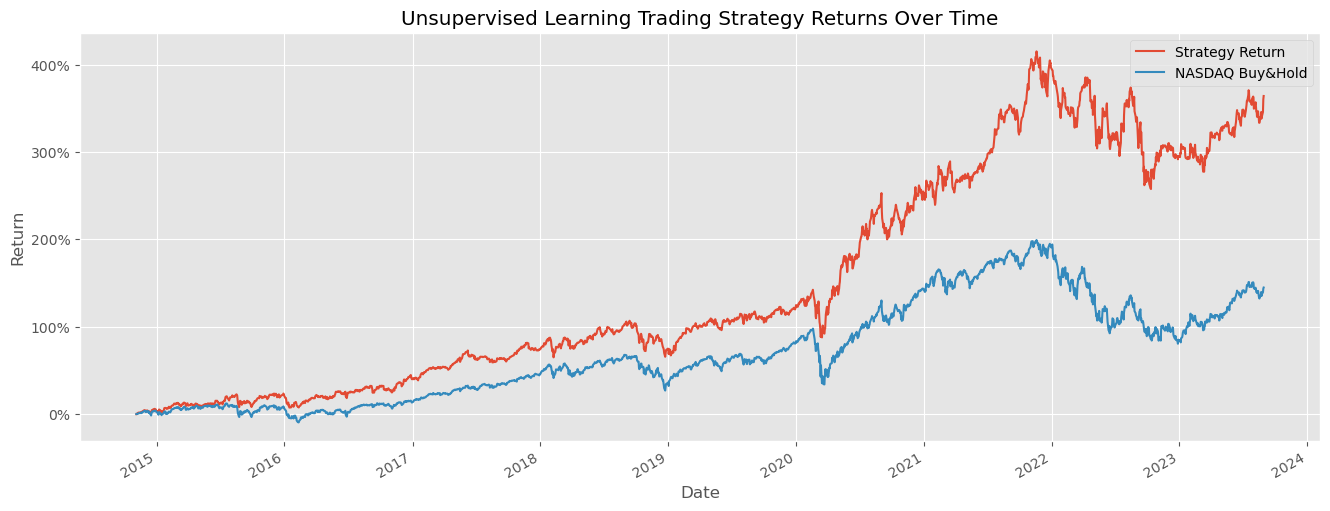

In [61]:
import matplotlib.ticker as mtick
plt.style.use('ggplot')

#Comput portfolio cumulative returns
portfolio_cumulative_return = np.exp(np.log1p(portfolio_df).cumsum())-1
portfolio_cumulative_return[:'2023-09-29'].plot(figsize=(16,6))

#Plot the cumulative returns
plt.title('Unsupervised Learning Trading Strategy Returns Over Time')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.ylabel('Return')
plt.show()